In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
from lib.torch_util import *

In [2]:
df = pd.read_csv('colloquial-indonesian-lexicon.csv')

In [3]:
columns = ['slang', 'formal']
df_grouped = df.groupby(columns).agg('count').reset_index()[columns]

In [4]:
class TextDataset(Dataset):
    def __init__(self, X, y, transform=None):
        super().__init__()
        self.X = X
        self.y = y
        
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        slang = self.X.iloc[idx]
        formal = self.y.iloc[idx]
        
        sample = {'slang': slang, 'formal': formal}
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

In [5]:
class ApplyPaddingToOrd(object):
    def __init__(self, max_len):
        self.max_len = max_len
        
    def __call__(self, sample):
        return {
            'slang': apply_padding_ord(sample['slang'], self.max_len), 
            'formal': apply_padding_ord(sample['formal'], self.max_len)
        }
    
    
class TextToOrd(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        return {
            'slang': lord(sample['slang']), 
            'formal': lord(sample['formal'])
        }
    
class ToTensor(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        slang, formal = sample['slang'], sample['formal']
        return {
            'slang': torch.from_numpy(np.array(slang)),
            'formal': torch.from_numpy(np.array(formal))
        }

In [6]:
batch_size = 512
max_len_slang = 61

In [16]:
X = df_grouped['slang']
y = df_grouped['formal']

X_train, X_test, X_val, y_train, y_test, y_val = split_train_test_val(X, y)
transform = transforms.Compose([
        TextToOrd(),
        ApplyPaddingToOrd(max_len_slang),
        ToTensor()
    ])
datasets = {
    'train': TextDataset(X_train, y_train, transform),
    'test': TextDataset(X_test, y_test, transform),
    'val': TextDataset(X_val, y_val, transform)
}

In [17]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        datasets[x], batch_size=batch_size, shuffle=True, num_workers=3
    ) for x in ['train', 'test', 'val']
}

In [18]:
import logging as log
logger = log.getLogger()
logger.setLevel(log.ERROR)

In [19]:
class Encoder(nn.Module):
    def __init__(self, batch_size, vocab_size, hidden_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, self.hidden_size, padding_idx=42)
        self.gru = nn.GRU(self.hidden_size, hidden_size)
        
    def forward(self, input, hidden, batch_size):
        # make into 1x1 dimension
        log.info('input shape: {}'.format(input.shape))
        embedded = self.embedding(
            input
        ).view(1, batch_size, -1)
        
        log.info('embedded result shape: {}'.format(embedded.shape))
        
        # gru or other RNN will output: output, hidden layer
        output, hidden = self.gru(embedded, hidden)
        
        log.info('result shape: {} , {}'.format(output.shape, hidden.shape))
        return output, hidden
    def init_hidden(self, batch_size, device=device):
        return torch.zeros(
            1, batch_size, self.hidden_size
            , device=device
        )

In [20]:
class AttnDecoder(nn.Module):
    def __init__(self, batch_size, hidden_size, vocab_size, dropout_p = 0.1, max_length=61):
        super(AttnDecoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.dropout_p = dropout_p
        
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=42)
        
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
        self.out = nn.Linear(self.hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden, eo, batch_size):
        # out shape: [1, batch_size, hidden_size]
        embedded = self.embedding(input).view(
            1, batch_size, -1
        )
        # out shape: [1, batch_size, hidden_size]
        embedded = self.dropout(embedded)
        
        log.info('hidden shape: {}'.format(hidden.shape))
        log.info('embedded shape: {}'.format(embedded.shape))
        
        attn_weights = F.softmax(
            self.attn(
                torch.cat( (embedded[0], hidden[0]), 1)
            ),
            dim=1
        )
        log.info('attention weight shape: {}'.format(attn_weights.shape))
        log.info('encoder output shape: {}'.format(eo.shape))
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(1)
            , eo
        ).view(1, batch_size, -1)
        log.info('attn applied shape: {}'.format(attn_applied.shape))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        log.info('output shape: {}'.format(output.shape))
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, attn_weights
    
    def init_hidden(self, batch_size, device=device):
        return torch.zeros(
            1, batch_size, self.hidden_size
            , device=device
        )
        

In [21]:
input_size = max_len_slang + 1
vocab_size = 122 + 2 #include eos and sos
embed_dim = max_len_slang + 1
hidden_size = 128
output_size = max_len_slang + 1
e = Encoder(batch_size, vocab_size, hidden_size)
d = AttnDecoder(batch_size, hidden_size, vocab_size)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
eoptimizer = optim.Adam(e.parameters())
doptimizer = optim.Adam(d.parameters())


In [22]:
def train(input_tensor, target_tensor, e, d, eop, dop, criterion, max_length=61):
    batch_size = input_tensor.shape[0]
    input_length = max_length
    output_length = max_length
    
    eh = e.init_hidden(batch_size)
    eop.zero_grad()
    dop.zero_grad()
    
    eoutputs = torch.zeros(max_length, batch_size, e.hidden_size)
    loss = 0
    
    for ei in range(input_length):
        eo, eh = e(
            input_tensor[:, ei].view(batch_size, 1),
            eh, 
            batch_size
        )
        log.info('eo shape: {}'.format(eo.shape))
        eoutputs[ei] = eo
    
    eoutputs = eoutputs.view(batch_size, input_length, e.hidden_size)
    # use only last context from encoder
    dh = eh
    dout = []
    decoder_input = torch.tensor([[SOS_TOKEN] * batch_size], device=device)
    for di in range(output_length):
        do, dh, da = d(decoder_input, dh, eoutputs, batch_size)
        topv, topi = do.topk(1)
        decoder_input = topi.squeeze().detach()
        dout.append(decoder_input)
#         log.info('predicted: {}, char: {}'.format(decoder_input, chr(decoder_input)))
        loss += criterion(do, target_tensor[:, di])
    loss.backward()
    eop.step()
    dop.step()

    return loss.item() / max_length
        
    

In [23]:
logger.setLevel(log.ERROR)

In [25]:
epochs = 10
losses = []
epoch_avg_losses = []

print_every = 1000
for ep in tqdm(range(epochs)):
    epoch_losses = []
    epoch_loss = 0
    
    for data in dataloaders['train']: 
        input_tensor, output_tensor = data['slang'], data['formal']
        log.info('input_tensor: {}'.format(input_tensor.shape))
        avg_loss = train(input_tensor, output_tensor, e, d, eoptimizer, doptimizer, criterion)
        losses.append(avg_loss)
        epoch_losses.append(avg_loss)
    
    epoch_loss = np.average(epoch_losses)
    epoch_avg_losses.append(epoch_loss)
        
        
    


  0%|          | 0/10 [00:00<?, ?it/s]



100%|██████████| 10/10 [01:32<00:00,  9.34s/it]


In [26]:
def evaluate_sentence(e, d, sentence, max_length=61, device=device):
    input_tensor = to_torch(pd.Series([encoded_from_sentence(sentence, max_length)]))[0]
    return evaluate(e, d, input_tensor, max_length=max_length, device=device)

def evaluate(e, d, input_tensor, max_length=61, device=device):
    with torch.no_grad():
        
        batch_size = 1
        eh = e.init_hidden(batch_size)
        input_length = input_tensor.size(0)
        output_length = input_tensor.size(0)

        eoutputs = torch.zeros(max_length, batch_size, e.hidden_size)
        loss = 0

        for ei in range(input_length):
            eo, eh = e(input_tensor[ei], eh, batch_size)
            eoutputs[ei] = eo[0,0]

        # use only last context from encoder
        dh = eh
        dout = []
        dattentions = torch.zeros(max_length, max_length)
        decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
        
        eoutputs = eoutputs.view(batch_size, input_length, e.hidden_size)
        for di in range(output_length):
            do, dh, da = d(decoder_input, dh, eoutputs, batch_size)
            topv, topi = do.topk(1)
                
            decoder_input = topi.squeeze().detach()
            log.info('[EVAL] predicted char: {}, {}'.format(decoder_input, chr(decoder_input)))
            dattentions[di] = da.data
            dout.append(decoder_input)
            
            

        return decoded_to_sentence(dout)



In [27]:
import matplotlib.pyplot as plt

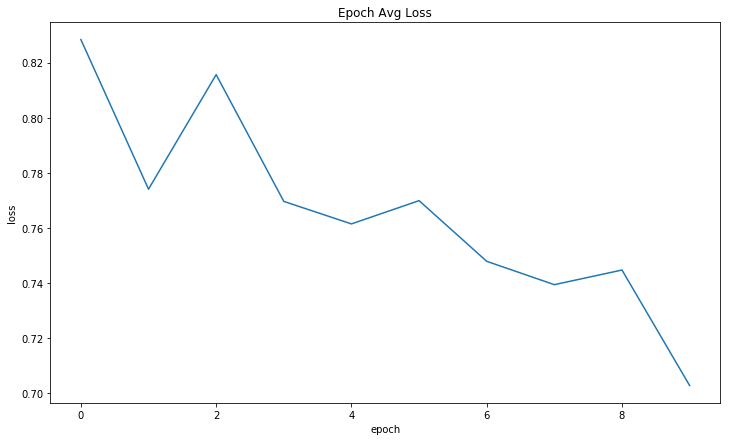

In [28]:
f, ax = plt.subplots(figsize=(12, 7))
plt.plot(list(np.arange(len(epoch_avg_losses))), epoch_avg_losses)
plt.title('Epoch Avg Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [29]:
i = 
print(decoded_to_sentence(data['slang'][0].numpy()))
print(decoded_to_sentence(data['formal'][0].numpy()))

blum
belum


In [216]:
df.iloc[X_train.iloc[:10].index]

,slang,formal,In-dictionary,context,category1,category2,category3
6073,kaa,kak,1,HBD kaa aku sayanggg kaa achaaa ????????,zeroisasi,elongasi,0
2506,sdh,sudah,1,Jgn percya kepada jasa hack facebook itu...moh...,abreviasi,0,0
10444,yg,yang,1,"yukk cek ig kita brayy, ada wristband kerennn....",abreviasi,0,0
5693,msih,masih,1,@gede.sudarma ckckck.. produk jaman dodol itu ...,abreviasi,0,0
818,rinduuuuuuuuuu,rindu,1,Rinduuuuuuuuuu @prillylatuconsina96 @aliandooo,elongasi,0,0
11818,bgt,banget,1,Kelas bgt nih dat suara nya @bsahetapy ???????,abreviasi,0,0
10016,jd,jadi,1,Kita cuma jualan kontak agen produsen dan supp...,abreviasi,0,0
5280,srng,sering,1,"Hati.a blm di jilbab mk.a gt,mlt.a nyerocooooo...",abreviasi,0,0
14566,stuju,setuju,1,G stuju ah,abreviasi,0,0
10423,yah,ya,1,Bisaan amat yah itu yang nge make up ny!!,anaptiksis,0,0


In [221]:
evaluate_sentence(e, d, 'srng')

'semang'

In [377]:
i = 34
sentence = df.iloc[X_train.iloc[:50].index[i]].slang
target = df.iloc[y_train.iloc[:50].index[i]].formal
print(sentence)
input_tensor = to_torch(pd.Series([encoded_from_sentence(sentence, max_len_slang)]))[0]
output_tensor = to_torch(pd.Series([encoded_from_sentence(target, max_len_slang)]))[0]
train(input_tensor, output_tensor, e, d, eoptimizer, doptimizer, criterion)
print(evaluate(e, d, input_tensor))

sm
sama


In [222]:
df_wt_prediction = df.iloc[X_train.iloc[:50].index]
df_wt_prediction['predicted_formal'] = df_wt_prediction['slang'].apply(
    lambda slang: evaluate_sentence(e, d, slang).replace(chr(1), '')
)

/home/arie/miniconda2/envs/data_analysis_351/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [223]:
from sklearn.metrics import accuracy_score

print('accuracy: {}'.format(
    accuracy_score(df_wt_prediction['formal'],  
                   df_wt_prediction['predicted_formal']))
)


accuracy: 0.28


In [224]:
df_wt_prediction = df.iloc[X_train.iloc[:100].index]
df_wt_prediction['predicted_formal'] = df_wt_prediction['slang'].apply(
    lambda slang: evaluate_sentence(e, d, slang).replace(chr(1), '')
)
print('accuracy: {}'.format(accuracy_score(df_wt_prediction['formal'],  df_wt_prediction['predicted_formal'])))

accuracy: 0.29


/home/arie/miniconda2/envs/data_analysis_351/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [225]:
df_wt_correct_prediction = df_wt_prediction[
    df_wt_prediction.formal == df_wt_prediction.predicted_formal
]

In [226]:
import altair as alt

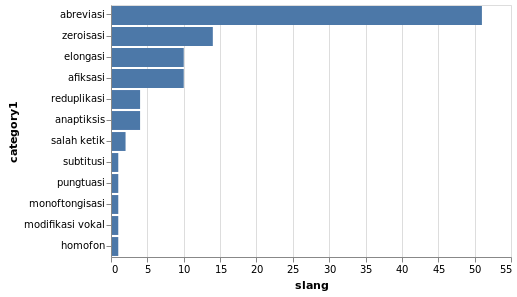

In [227]:
agg_all = df_wt_prediction.groupby(
    'category1'
).agg('count')['slang'].reset_index()
alt.Chart(agg_all).mark_bar().encode(
    x='slang',
    y=alt.Y(
        'category1',
        sort=alt.EncodingSortField(
            field='slang',
            op='sum',
            order='descending'
        )
    )
)

In [231]:
df_wt_prediction.iloc[50:60][['slang', 'formal', 'predicted_formal']]

,slang,formal,predicted_formal
3954,sj,saja,saja
1706,sndiri,sendiri,senari
13445,engga,enggak,enggak
5448,bbrpa,beberapa,begaaaa
4937,dh,deh,dah
5120,bs,bisa,bisi
6619,bgt,banget,banget
4339,yg,yang,yang
1666,yg,yang,yang
8900,gara2,gara-gara,engaraa


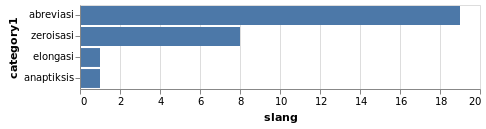

In [228]:
agg = df_wt_correct_prediction.groupby(
    'category1'
).agg('count')['slang']
agg = agg.reset_index()
alt.Chart(agg).mark_bar().encode(
    x='slang',
    y=alt.Y(
        'category1',
        sort=alt.EncodingSortField(
            field='slang',
            op='sum',
            order='descending'
        )
    )
)

In [458]:
all_vs_correct_prediction = pd.merge(
    agg_all, agg.rename(
        index=str, columns={
        'category1': 'correct_pred_category1', 
        'slang': 'correct_pred_slang'
    })
, left_on='category1', right_on='correct_pred_category1', how='left').fillna(0)
all_vs_correct_prediction['correct_pct'] = all_vs_correct_prediction[
    'correct_pred_slang'
] / all_vs_correct_prediction['slang']

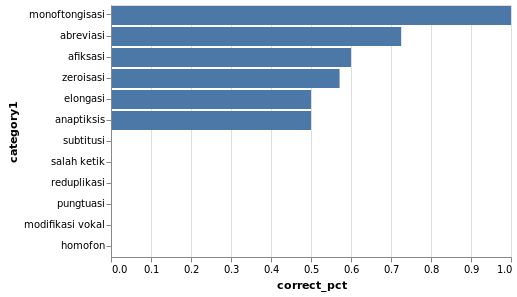

In [467]:
alt.Chart(all_vs_correct_prediction).mark_bar().encode(
    x='correct_pct:Q',
    y=alt.Y(
        'category1:N'
        , sort=alt.EncodingSortField(
            field='correct_pct',
            op='sum',
            order='descending'
        )
    )
)

In [472]:
df_wt_correct_prediction.shape

(59, 8)